# Timeseries modelling using Autoregressive Models.
Here I'll try to model a financial time series process using the AR model implemented in PyMC3

I'm following the tutorial:
http://docs.pymc.io/notebooks/AR.html

In [1]:
## Import necessary stuff
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import pymc3 as pm

/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Fix without file modification (known bug in pandas_datareader)
## From https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like
from datetime import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

In [3]:
## Extract data from the OECD API 

In [4]:
## But lets look something interesting, like the OECD agricultural outlook 
df = web.DataReader('PPPGDP', 'oecd', end=datetime(2018, 8, 1))
## Select values from a country 
mex_pppgdp = df.xs('Mexico',level=1,axis=1)
## some values in another level, remember the values are hierarchical
ppp_Gdp_global = df.xs('Purchasing Power Parities',level=0,axis=1)

In [5]:
## Extract data from iex api

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['TSLA', 'IVV', 'CX']

# We would like all available data from 01/01/2000 until 12/31/2016.
start = datetime(2015, 2, 9)
end = datetime(2018,8, 15)

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, 'iex', start, end)


5y


In [6]:
## Panel_data is a dictionary
sp5 = panel_data['IVV']
## We se
sp5.index = pd.DatetimeIndex(sp5.index)


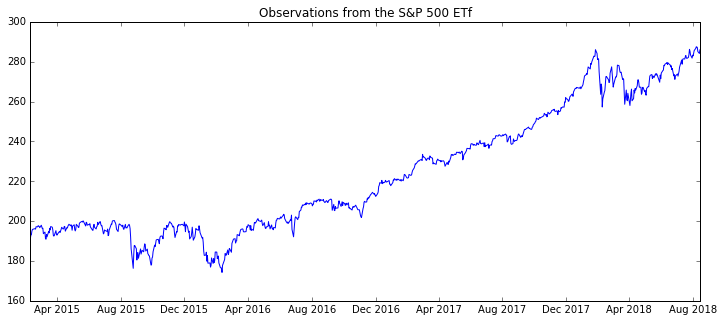

In [7]:
fig = plt.figure(figsize=(12,5));
plt.plot(sp5.close)
plt.title('Observations from the S&P 500 ETf')

In [15]:
## Select last 100 points
data = sp5[-100:].open

In [9]:
## Modelling as an AR model
import pymc3 as pm

In [17]:
y = data.values
tau = 1.0
with pm.Model() as ar1:
    beta = pm.Normal('beta', mu=0, sd=tau)
    cosa = pm.AR('y', beta, sd=1.0, observed=y)
    trace = pm.sample(1000, cores=3,tune=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta]
100%|██████████| 1100/1100 [00:00<00:00, 1492.82it/s]
The acceptance probability does not match the target. It is 0.9194801549874453, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9304276333169894, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9511614285452524, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bd95bb850>,
      dtype=object)

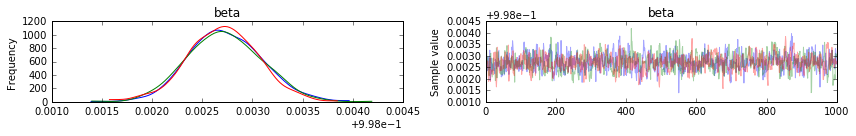

In [70]:
pm.traceplot(trace)

In [21]:
X = np.arange(len(data.values))
Y = data.values

In [22]:
Y = Y.reshape(Y.shape[0],1)
X = X.reshape(X.shape[0],1)
X = np.arange(len(X)).reshape(X.shape[0],1)

In [100]:
## Model as a Gaussian Process MCMC
import theano.tensor as tt
from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model1:

    l = pm.Gamma("l",alpha=2,beta=1)
    n = pm.HalfCauchy("n",beta=5)
    
    cov = n ** 2 * pm.gp.cov.Matern52(1,l)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f",X=X)
    
    sigma = pm.HalfCauchy("sigma",beta=5)
    v = pm.Gamma("v",alpha=2,beta=0.1)
    
    #y_ = pm.StudentT("y",mu=f,lam=1.0/sigma,nu=v,observed=y)
    y_ = pm.Normal("y",mu=f,sd=sigma ,observed=Y)
    trace_m1 = pm.sample(100)
    #trace_m = pm.fit(method='advi', n=150000)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

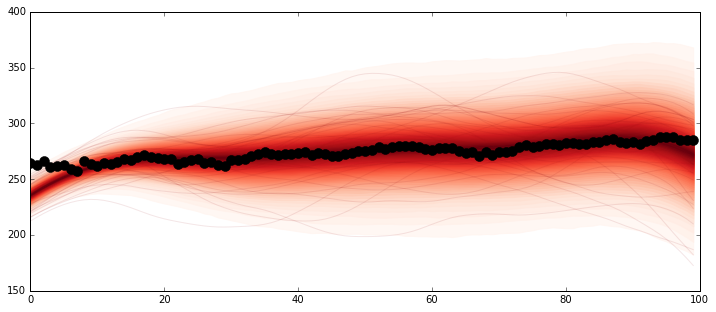

In [79]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax,trace_m["f"], X);

ax.plot(X, y, 'o', color="k", ms=10);

In [103]:
## Model as a Gaussian Process ADVI / periodic
import theano.tensor as tt
from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model2:

    ## Periodic things
    # prior for periodic lengthscale, or frequency
    #l_per = pm.Uniform('l_per', lower=1e-5, upper=10)
    l_per = pm.Flat('l_per')
    # uninformative prior on the periodic amplitude
    log_s2_p = pm.Flat('log_s2_p')
    s2_p = pm.Deterministic('s2_p', tt.exp(log_s2_p))

    # the periodic "signal" covariance
    signal_cov = s2_p * pm.gp.cov.Cosine(1, l_per)    
    ######
    tau = pm.HalfNormal('tau',sd=1)

    # uninformative prior on the drift amplitude
    log_s2_d = pm.Uniform('log_s2_d', lower=-10, upper=5)
    s2_d = pm.Deterministic('s2_d', tt.exp(log_s2_d))    
    
    l = pm.Gamma("l",alpha=2,beta=1)
    n = pm.HalfCauchy("n",beta=5)
    
    cov1 = (n ** 2) * pm.gp.cov.Matern52(1,l) * s2_d + tau
    cov = signal_cov + cov1
    
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f",X=X)
    
    sigma = pm.HalfCauchy("sigma",beta=5)
    v = pm.Gamma("v",alpha=2,beta=0.1)
    
    #y_ = pm.StudentT("y",mu=f,lam=1.0/sigma,nu=v,observed=y)
    y_ = pm.Normal("y",mu=f,sd=sigma ,observed=Y)
    trace_m1 = pm.sample(100)
    #trace_m = pm.fit(method='advi', n=25500)
    #trace = trace_m.sample(draws=5000)
    

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v_log__, sigma_log__, f_rotated_, n_log__, l_log__, log_s2_d_interval__, tau_log__, log_s2_p, l_per]
100%|██████████| 600/600 [41:16<00:00,  4.13s/it]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.01791089223126426, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.947595610209237, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


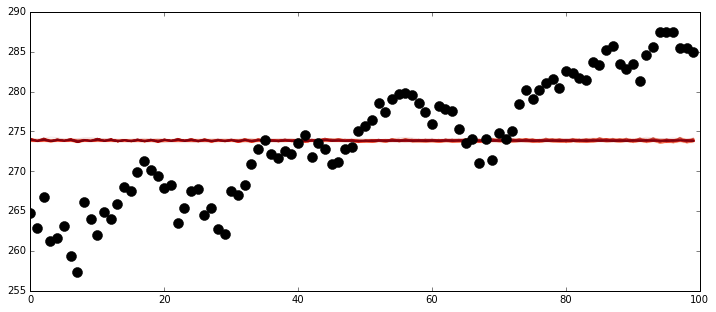

In [104]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax,trace_m1["f"], X);

ax.plot(X, y, 'o', color="k", ms=10);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7be03bb110>,
      dtype=object)

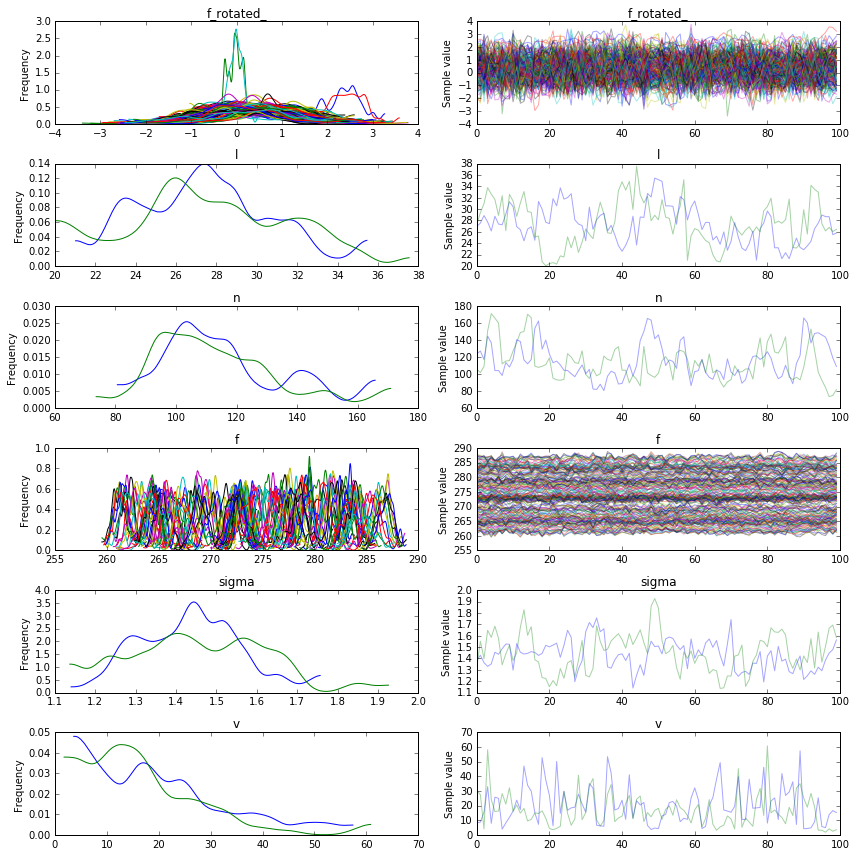

In [29]:
pm.traceplot(trace_m1)

In [66]:
## Predictions
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 100, n_new)[:,None]

# add the GP conditional to the model, given the new X values
#with model1:
#    f_pred = gp.conditional("f_pred", X_new)
    

In [67]:
# Sample from the GP conditional distribution
with model1:
    pred_samples = pm.sample_ppc(trace_m2, vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:02<00:00, 41.16it/s]


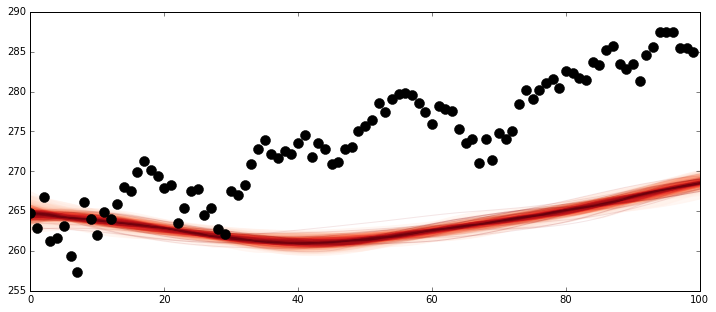

In [68]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax,pred_samples["f_pred"], X_new);

ax.plot(X, y, 'o', color="k", ms=10);

In [51]:
## Model 2
## Model as a Gaussian Process
import theano.tensor as tt
from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model2:

    l = pm.Gamma("l",alpha=2,beta=1)
    n = pm.HalfCauchy("n",beta=5)
    
    cov = n ** 2 * pm.gp.cov.Matern52(1,l)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f",X=X)
    
    sigma = pm.HalfCauchy("sigma",beta=5)
    #v = pm.Gamma("v",alpha=2,beta=0.1)
    
    #y_ = pm.StudentT("y",mu=f,lam=1.0/sigma,nu=v,observed=y)
    y_ = pm.Normal("y",mu=f,sd=sigma ,observed=y)
    #trace_m2 = pm.sample(100)

AttributeError: 'MultiTrace' object has no attribute 'T'

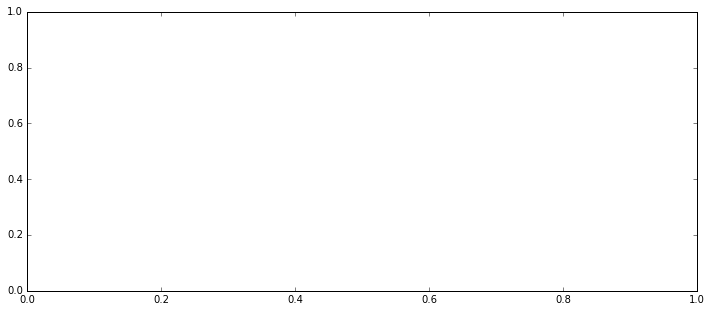

In [18]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5));
ax = fig.gca()
m1 = plot_gp_dist(ax, trace, X,palette='Reds');